In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from torchvision.models._utils import IntermediateLayerGetter

from models.modeling.deeplab import *

from PIL import Image
from skimage.transform import resize

from models.model import JointModel
from dataloader.vocabulary import Vocabulary

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Args:
    lr = 3e-4
    batch_size = 64
    num_workers = 4
    image_encoder = "deeplabv3_plus"
    num_layers = 1
    num_encoder_layers = 1
    dropout = 0.25
    skip_conn = False
    model_path = "./saved_model/talk2car/jrm_baseline_drop_0.25_bs_64_el_1_sl_40_bce_0.58126.pth"
    dataroot = "/ssd_scratch/cvit/kanishk/"
    glove_path = "/ssd_scratch/cvit/kanishk/glove/"
    vocabulary_path="/home/kanishk/vigil/autonomous_grounding/dataloader/vocabulary.txt"
    dataset = "talk2car"
    task = "talk2car"
    split = "val"
    max_len = 40 
    image_dim = 448
    mask_dim = 448
    mask_thresh = 0.3
    area_thresh = 0.4
    topk = 10
    metric = "pointing_game"

args = Args()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()
print(f'{device} being used with {n_gpu} GPUs!!')

cuda being used with 2 GPUs!!


In [5]:
### Creating Vocabulary
vocabulary = Vocabulary(args.vocabulary_path, args.glove_path, args.max_len)

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
resize = transforms.Resize((args.image_dim, args.image_dim))

In [7]:
transform = transforms.Compose([resize, to_tensor, normalize])

In [8]:
return_layers = {"layer2": "layer2", "layer3": "layer3", "layer4": "layer4"}

model = DeepLab(num_classes=21, backbone="resnet", output_stride=16)
model.load_state_dict(torch.load("./models/deeplab-resnet.pth.tar")["state_dict"])

image_encoder = IntermediateLayerGetter(model.backbone, return_layers)

for param in image_encoder.parameters():
    param.requires_grad_(False)
    
in_channels = 2048
out_channels = 512
stride = 2

joint_model = JointModel(
    in_channels=in_channels,
    out_channels=out_channels,
    stride=stride,
    num_layers=args.num_layers,
    num_encoder_layers=args.num_encoder_layers,
    dropout=args.dropout,
    skip_conn=args.skip_conn,
    mask_dim=args.mask_dim,
)

if n_gpu > 1:
    image_encoder = nn.DataParallel(image_encoder)
    joint_model = nn.DataParallel(joint_model)  ## toggle this comment if you get key error

state_dict = torch.load(args.model_path)
if "state_dict" in state_dict:
    state_dict = state_dict["state_dict"]
joint_model.load_state_dict(state_dict) 


<All keys matched successfully>

In [9]:
joint_model.to(device)
image_encoder.to(device)

image_encoder.eval();
joint_model.eval();

In [10]:
img_path = input("Image path: ")

Image path: 006225.jpeg


In [11]:
command = input("Input Command: ")

Input Command: follow the red car


In [12]:
input_image = Image.open(img_path)
resized_image = np.array(input_image.resize((448, 448)))

image = transform(input_image)

phrase, phrase_mask = vocabulary.tokenize(command)

In [13]:
### Prepare for Model
image = image.cuda(non_blocking=True).unsqueeze(0)
image_mask = torch.ones(1, 14 * 14, dtype=torch.int64).cuda(non_blocking=True)

phrase = phrase.unsqueeze(0).cuda(non_blocking=True)
phrase_mask = phrase_mask.unsqueeze(0).cuda(non_blocking=True)

In [14]:
### Input to Model

with torch.no_grad():
    image = image_encoder(image) 
    
output_mask = joint_model(image, phrase, image_mask, phrase_mask)

In [15]:
output_mask = output_mask.detach().cpu().squeeze()

In [16]:
threshold = float(input('threshold for mask: '))
assert 0<= threshold < 1 

threshold for mask: 0.2


In [17]:
im_seg = np.array(resized_image)[:] / 2

predicts = (output_mask > threshold).numpy()

im_seg[:, :, 0] += predicts.astype('uint8') * 100
im_seg = im_seg.astype('uint8')

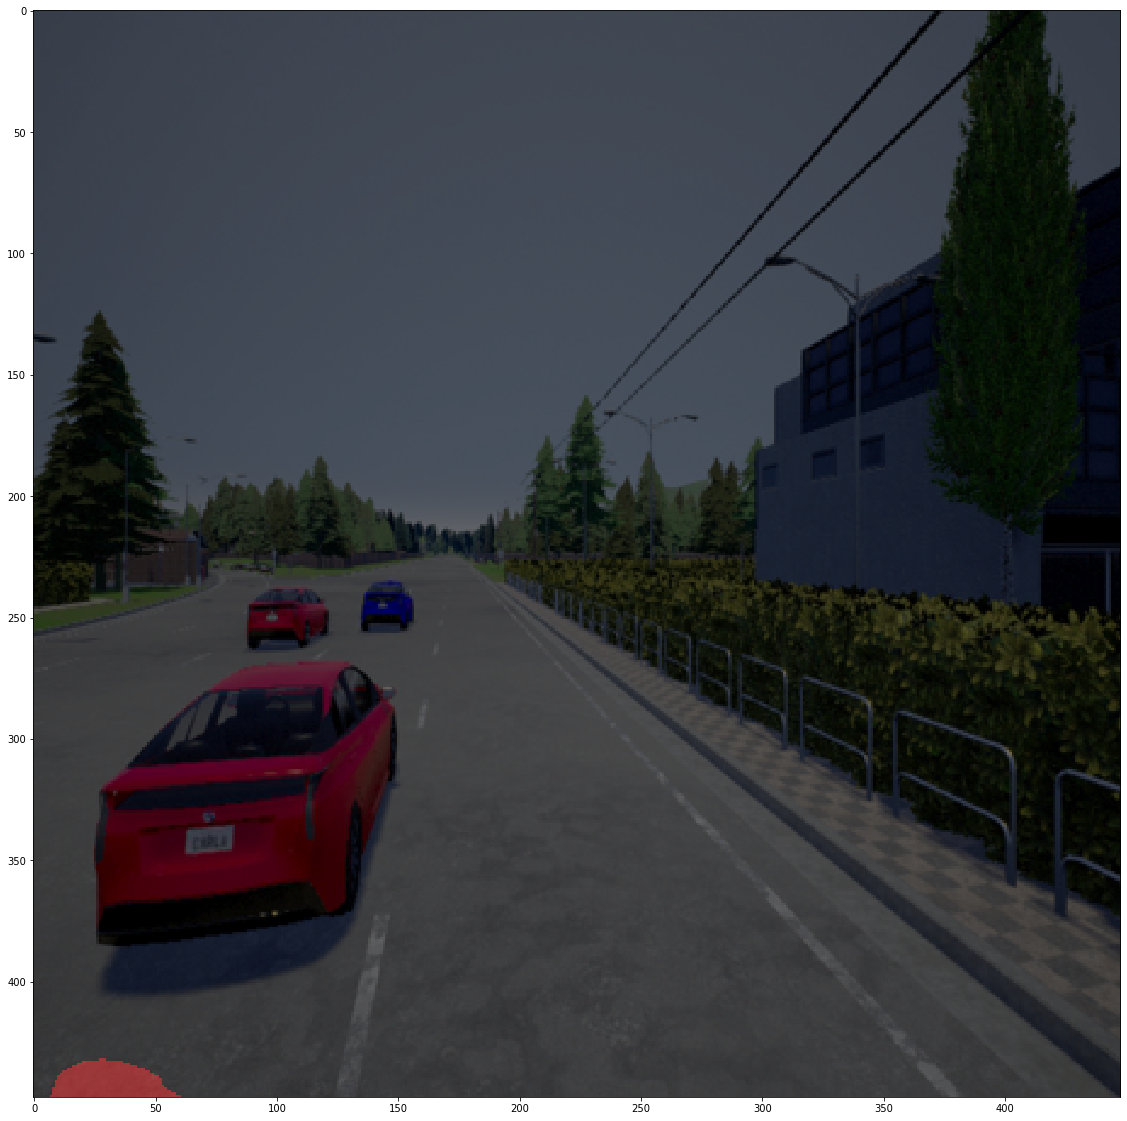

In [18]:
## Display the Output

figure = plt.figure(figsize=(20, 20))
plt.imshow(im_seg)